In [1]:
import numpy as np, basic, curvedsky as cs, plottools as pl, healpy as hp, binning as bn, analysis as ana, cmb as CMB, local, tqdm
from matplotlib.pyplot import *
import warnings
warnings.filterwarnings("ignore")
Tcmb  = 2.726e6    # CMB temperature
ac2rad = np.pi/180./60.

In [23]:
# define parameters
lmax  = 1700       # maximum multipole of output normalization
rlmin, rlmax = 50, lmax  # reconstruction multipole range
sig   = 3.
L = np.linspace(0,lmax,lmax+1)
# for sim
simn = 50
beta = 0.35*np.pi/180.
freq = 217
freq = 0

In [24]:
quad = ['EB']
color = ['m']

In [25]:
ucl = CMB.read_camb_cls('data_local/cosmo2017_10K_acc3_scalCls.dat',output='array')[:,:lmax+1]
lcl = CMB.read_camb_cls('data_local/cosmo2017_10K_acc3_lensedCls.dat',ftype='lens',output='array')[:,:lmax+1]
nl  = np.zeros((4,lmax+1))
nl[0,:] = .5*(sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl

In [37]:
Ag = {}
#Ag['TE'] = cs.norm_imag.qte('amp',rlmax,rlmin,rlmax,lcl[3,:],ocl[0,:],ocl[1,:])[0]
Ag['TB'] = cs.norm_imag.qtb('amp',rlmax,rlmin,rlmax,ocl[3,:],ocl[0,:],ocl[2,:])[0]
#Ag['EE'] = cs.norm_imag.qee('amp',rlmax,rlmin,rlmax,lcl[1,:],ocl[1,:])[0]
Ag['EB'] = cs.norm_imag.qeb('amp',rlmax,rlmin,rlmax,ocl[1,:]-ocl[2,:],ocl[1,:],ocl[2,:])[0]
Ag['BB'] = cs.norm_imag.qbb('amp',rlmax,rlmin,rlmax,ocl[1,:]-ocl[2,:],ocl[2,:])[0]

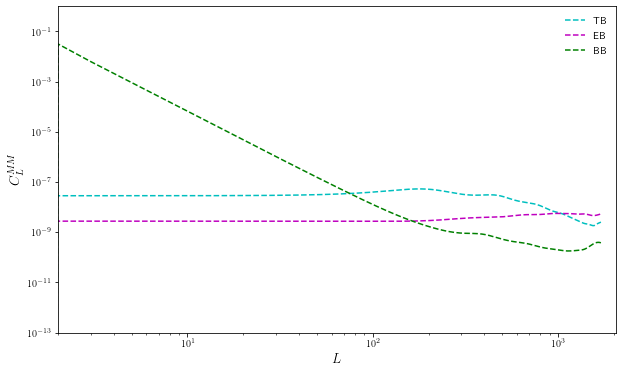

In [38]:
pl.plot_1dstyle(usetex=True,fsize=[10,6],xmin=2,xmax=2048,ymin=1e-13,ymax=1,xlog=True,ylog=True,ylab=r'$C^{MM}_L$')
for qi, (q,c) in enumerate(zip(['TB','EB','BB'],['c','m','g'])):
    plot(Ag[q],color=c,ls='--',label=q)
legend()

In [7]:
if freq==0:
    M = hp.read_map('/global/homes/t/toshiyan/scratch/plk/mask/COM_Mask_Lensing_2048_R2.00_a5.0deg.fits')
else:
    M0 = hp.read_map('data/mask/PR3_HFI_'+str(freq)+'_0.5deg.fits',field=0)
    M1 = hp.read_map('data/mask/PR3_HFI_'+str(freq)+'_0.5deg.fits',field=1)
    M = M0*M1

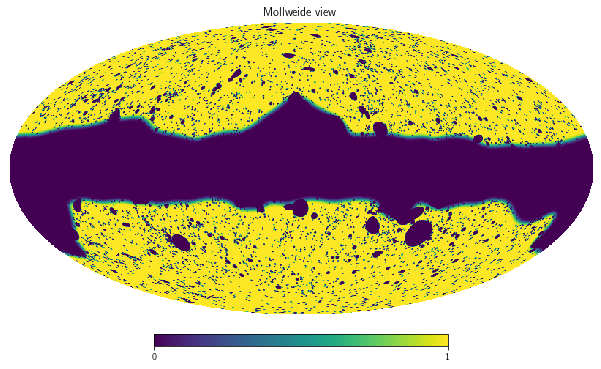

In [8]:
hp.mollview(M)

In [9]:
M = hp.ud_grade(M,1024)
palm = cs.utils.hp_map2alm(1024,lmax,lmax,M)
clmm = cs.utils.alm2cl(lmax,palm)

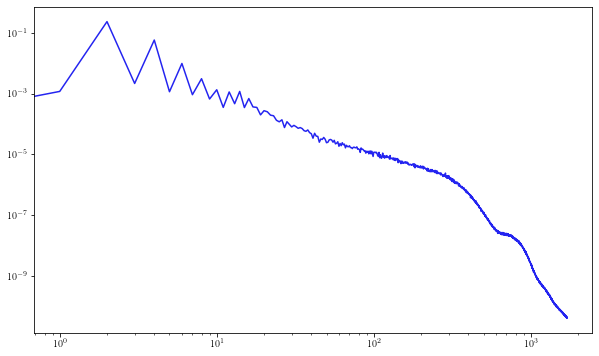

In [10]:
loglog(clmm)

In [11]:
np.mean(M)

0.5694703651914375

In [12]:
'''
alms = hp.read_alm('/project/projectdirs/sobs/v4_sims/mbs/cmb/fullskyLensedUnabberatedCMB_alm_set00_'+str(1).zfill(5)+'.fits',hdu=(1,2,3))
Ealm = cs.utils.lm_healpy2healpix( alms[1], 5100 ) [:lmax+1,:lmax+1] / Tcmb
Balm = cs.utils.lm_healpy2healpix( alms[2], 5100 ) [:lmax+1,:lmax+1] / Tcmb
Ealm, Balm = ana.ebrotate(beta,Ealm,Balm)
Ealm, Balm = cs.utils.mulwin_spin(Ealm,Balm,M)
Ealm += cs.utils.gauss1alm(lmax,nl[1,:])
Balm += cs.utils.gauss1alm(lmax,nl[2,:])
Fl = np.zeros((3,lmax+1,lmax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]
Ealm *= Fl[1,:,:]
Balm *= Fl[2,:,:]
glm = cs.rec_iamp.qeb(lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm)
cli = np.zeros((2,lmax+1))
cli[0] = cs.utils.alm2cl(lmax,Ag['EB'][:,None]*glm,palm)
'''

"\nalms = hp.read_alm('/project/projectdirs/sobs/v4_sims/mbs/cmb/fullskyLensedUnabberatedCMB_alm_set00_'+str(1).zfill(5)+'.fits',hdu=(1,2,3))\nEalm = cs.utils.lm_healpy2healpix( alms[1], 5100 ) [:lmax+1,:lmax+1] / Tcmb\nBalm = cs.utils.lm_healpy2healpix( alms[2], 5100 ) [:lmax+1,:lmax+1] / Tcmb\nEalm, Balm = ana.ebrotate(beta,Ealm,Balm)\nEalm, Balm = cs.utils.mulwin_spin(Ealm,Balm,M)\nEalm += cs.utils.gauss1alm(lmax,nl[1,:])\nBalm += cs.utils.gauss1alm(lmax,nl[2,:])\nFl = np.zeros((3,lmax+1,lmax+1))\nfor l in range(rlmin,rlmax):\n    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]\nEalm *= Fl[1,:,:]\nBalm *= Fl[2,:,:]\nglm = cs.rec_iamp.qeb(lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm)\ncli = np.zeros((2,lmax+1))\ncli[0] = cs.utils.alm2cl(lmax,Ag['EB'][:,None]*glm,palm)\n"

In [13]:
cl = np.zeros((simn,lmax+1))
EB = np.zeros((simn,lmax+1))
for i in tqdm.tqdm(range(simn)):
    cl[i,:], EB[i,:] = local.sim_iamp(i,M,palm,lmax,rlmin,rlmax,Ag,ocl,lcl,nl,beta,freq)

100%|██████████| 50/50 [30:54<00:00, 37.10s/it]


In [14]:
import importlib
importlib.reload(local)

<module 'local' from '/global/u1/t/toshiyan/Work/Ongoing/ilens/local.py'>

In [15]:
ebeta1 = local.est_beta(cl[:,1:],clmm[1:]*beta)

In [16]:
mebeta1 = np.mean(ebeta1)
print(mebeta1,np.std(ebeta1)/mebeta1,np.std(ebeta1)/np.mean(ebeta1)*.35)

0.49578062590666727 0.1715954217904514 0.06005839762665798


In [17]:
ebeta2 = local.est_beta(EB[:,rlmin:],lcl[1,rlmin:]*2*beta)

In [18]:
mebeta2 = np.mean(ebeta2)
print(mebeta2,np.std(ebeta2)/mebeta2,np.std(ebeta2)/np.mean(ebeta2)*.35)

0.9419001382598853 0.16052459918266107 0.05618360971393137


In [19]:
betas = np.array( [ebeta1/mebeta1, ebeta2/mebeta2] ).T
print(np.shape(betas))

(50, 2)


In [20]:
corr = np.corrcoef(betas[:,0],betas[:,1])
print(corr)

[[1.         0.95476552]
 [0.95476552 1.        ]]


In [21]:
wi = np.array( [ np.sum(np.linalg.inv(np.cov(np.delete(betas,i,0),rowvar=0)),axis=0) for i in range(simn) ] )
wt = np.array( [ np.sum(wi[i,:]) for i in range(simn)] )
A  = np.array( [ np.sum(wi[i,:]*betas[i,:])/wt[i] for i in range(simn)] )
print(np.mean(A),np.std(A)*.35)

1.0002408317835785 0.057149032503606284


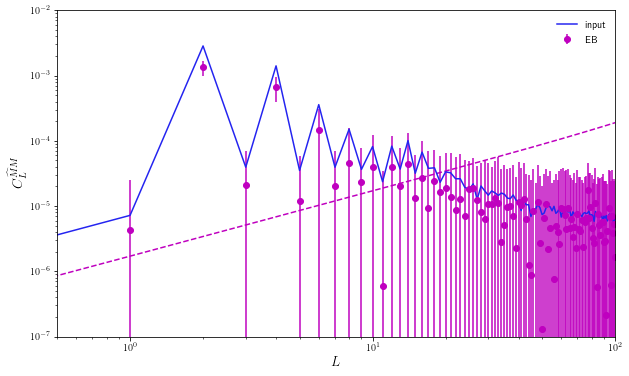

In [22]:
s = L.copy()
pl.plot_1dstyle(usetex=True,fsize=[10,6],xmin=0.5,xmax=100,ymin=1e-7,ymax=1e-2,xlog=True,ylog=True,ylab=r'$C^{\widehat{M}M}_L$')
plot(L,s*Ag['EB'],color='m',ls='--')
errorbar(L,s*np.mean(cl,axis=0),yerr=s*np.std(cl,axis=0),fmt='o',label='EB',color='m')
plot(L,s*clmm*beta,ls='-',label='input')
legend()
#savefig('fig_sim.pdf')